In [5]:
import numpy as np
from numba import jit
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit_clus_size_pro as toy
import matplotlib.pyplot as plt



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [6]:

model = toy.SmolModel(None,None)


true_parameters = [0.0002, 0.0025, 500]


times = np.linspace(0, 97, 9700)

org_values = model.simulate(true_parameters, times)

print(org_values)

print(org_values.shape)


[[5.00000000e+00 2.47500000e+03 9.84937059e+00 9.80101010e+01]
 [4.99762595e+00 2.47003009e+03 9.84936644e+00 9.80100470e+01]
 [4.99525427e+00 2.46507385e+03 9.84935401e+00 9.80098853e+01]
 ...
 [8.44548969e+00 2.29577538e+01 8.73159430e-01 2.77129946e+00]
 [8.45747169e+00 2.31107276e+01 8.73711704e-01 2.77217303e+00]
 [8.46947746e+00 2.32645533e+01 8.74265984e-01 2.77305137e+00]]
(9700, 4)


In [7]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str


Perfect data

In [8]:
values = org_values
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)
mcmc.set_max_iterations(ITERS)
chains_1 = mcmc.run()
print(chains_1)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.1


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_75416/3369582945.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pints/_mcmc/_haario_bardenet_ac.py:89: UserWarning: The class `pints.AdaptiveCovarianceMCMC` is deprecated. Please use `pints.HaarioBardenetACMC` instead.
  warnings.warn(


1     6      0         0         0          0:00.6
2     9      0         0         0          0:00.6
3     12     0         0         0          0:00.6
20    63     0         0         0          0:01.1
40    123    0         0         0          0:02.7
60    183    0         0         0          0:12.1
80    243    0         0         0          0:20.1
100   303    0         0         0          0:24.2
120   363    0         0         0          0:29.4
140   423    0         0         0.00709    0:31.4
160   483    0         0         0.00621    0:32.9
180   543    0         0         0.00552    0:35.3
Initial phase completed.
200   603    0         0         0.00498    0:37.8
220   663    0.0136    0.00452   0.0226     0:39.4
240   723    0.029     0.0207    0.0415     0:40.5
260   783    0.0421    0.0192    0.046      0:41.6
280   843    0.0391    0.0249    0.0534     0:42.7
300   903    0.0365    0.0299    0.0565     0:43.9
320   963    0.0374    0.0498    0.0685     0:45.1
340   

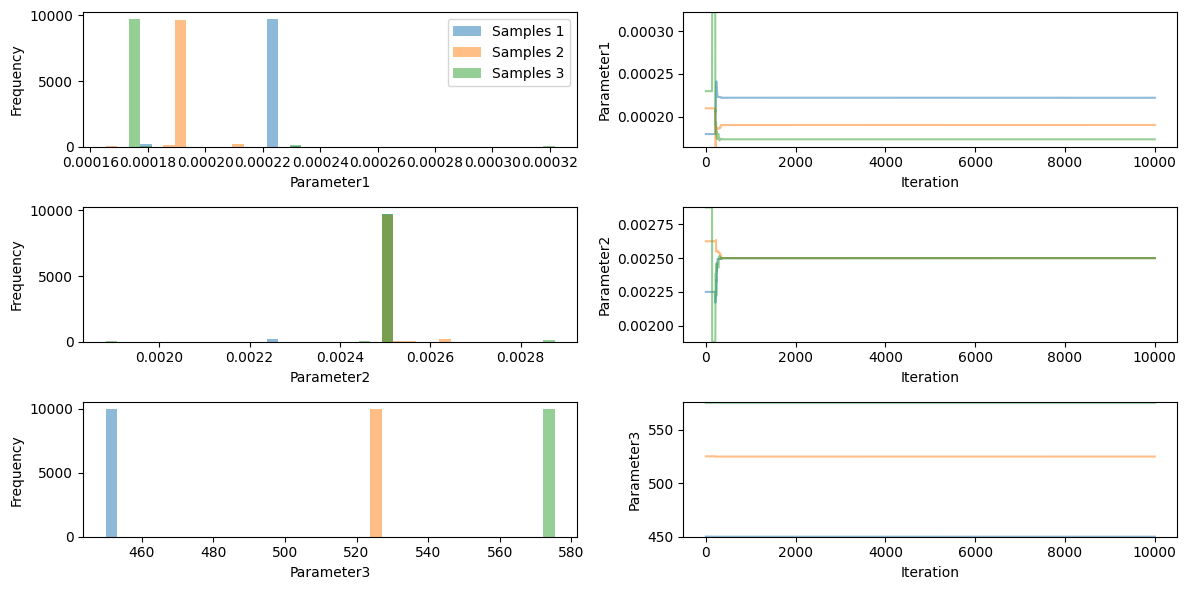

<class '__main__.MyMCMCSummary'>
param    mean      std.      2.5%      25%       50%       75%       97.5%     rhat      ess    ess per sec.
-------  --------  --------  --------  --------  --------  --------  --------  --------  -----  --------------
b        0.000196  2.01e-05  0.000174  0.000174  0.000191  0.000222  0.000222  4.94e+12  nan    nan
p        0.0025    5.13e-12  0.0025    0.0025    0.0025    0.0025    0.0025    1e+05     34.2   0.0574
N        517       51.4      450       450       525       575       575       3.41e+12  5.29   0.00889


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pints/_diagnostics.py:16: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / (np.std(x) * np.sqrt(len(x)))


In [10]:
pints.plot.trace(chains_1)
plt.savefig("perfect_data_moments_distribution.png")
plt.show()

parameter_names = ["b","p","N"]
results_1 = MyMCMCSummary(chains=chains_1[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results_1))
print(results_1)

Multiplicative noise

In [11]:
noise = 1
values = org_values *(1 + noise * np.random.normal(0, 1, org_values.shape))
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)
mcmc.set_max_iterations(ITERS)
chains_2 = mcmc.run()
print(chains_2)

/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_75416/3678871583.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.1
1     6      0         0         0          0:00.1
2     9      0         0         0          0:00.1
3     12     0         0         0          0:00.1
20    63     0         0         0          0:06.5
40    123    0.0244    0         0          0:11.3
60    183    0.0164    0.0164    0          0:13.0
80    243    0.0123    0.0123    0          0:14.2
100   303    0.0099    0.0099    0.0099     0:14.7
120   363    0.00826   0.00826   0.00826    0:16.1
140   423    0.00709   0.00709   0.0142     0:18.2
160   483    0.00621   0.00621   0.0124     0:20.6
180   543    0.00552   0.00552   0.011      0:20.8
Initial phase completed.
200   603    0.00498   0.00498   0.00995    0:22.7
220   663    0.0271    0.00452   0.0136     0:24.6
240   723    0.029     0.0166    0.0373     0:25.7
260   783   

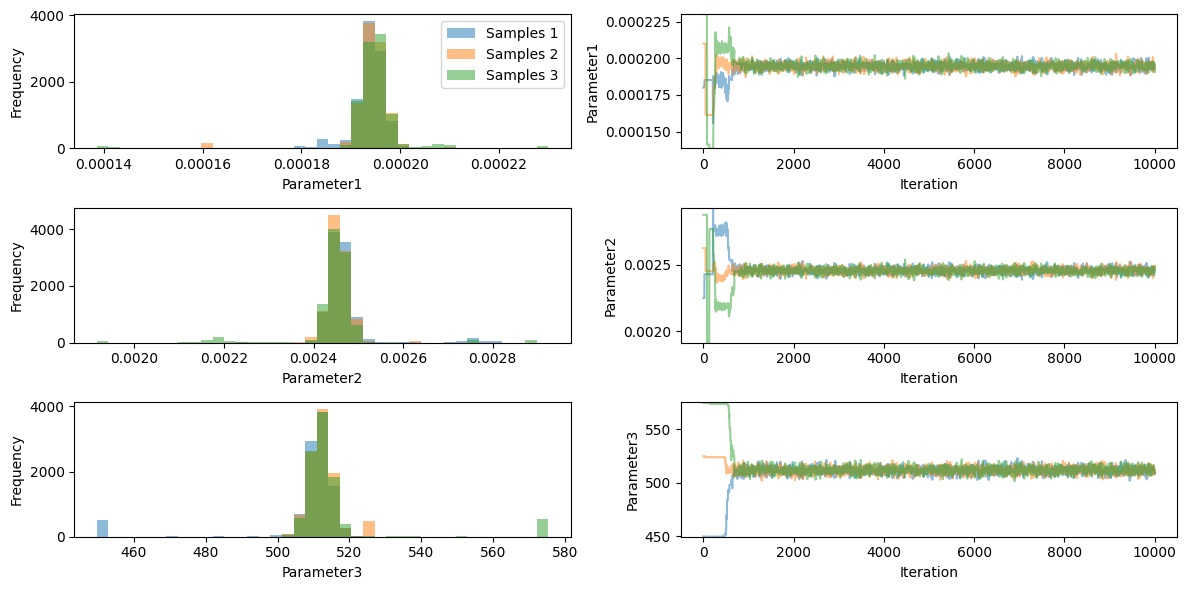

<class '__main__.MyMCMCSummary'>
param    mean      std.      2.5%     25%       50%       75%       97.5%     rhat    ess       ess per sec.
-------  --------  --------  -------  --------  --------  --------  --------  ------  --------  --------------
b        0.000195  2.14e-06  0.00019  0.000193  0.000195  0.000196  0.000199  1       1.02e+03  1.78
p        0.00246   2.07e-05  0.00242  0.00244   0.00246   0.00247   0.0025    1       1.06e+03  1.84
N        512       3.03      506      510       512       514       518       1       1.2e+03   2.09


In [12]:
pints.plot.trace(chains_2)
plt.savefig("noisy_data_multiplicative_moments_distribution.png")
plt.show()

parameter_names = ["b","p","N"]
results_2 = MyMCMCSummary(chains=chains_2[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results_2))
print(results_2)

Additive noise

In [13]:
noise = 1
values = org_values + noise * np.random.normal(0, 0.25, org_values.shape)
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)
mcmc.set_max_iterations(ITERS)
chains_3 = mcmc.run()
print(chains_3)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.1
1     6      0         0         0          0:00.1
2     9      0         0         0          0:00.1
3     12     0         0         0          0:00.1


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_75416/1462043690.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


20    63     0         0         0.0476     0:01.0
40    123    0         0         0.0244     0:06.1
60    183    0         0         0.0164     0:09.8
80    243    0         0         0.0123     0:13.8
100   303    0         0         0.0099     0:16.9
120   363    0         0         0.00826    0:18.4
140   423    0         0         0.00709    0:20.8
160   483    0         0         0.00621    0:23.0
180   543    0         0         0.00552    0:25.4
Initial phase completed.
200   603    0         0         0.00498    0:27.3
220   663    0.0181    0.0181    0.0271     0:29.5
240   723    0.029     0.029     0.0539     0:30.7
260   783    0.0383    0.0345    0.0613     0:31.8
280   843    0.0356    0.0463    0.0641     0:33.0
300   903    0.0399    0.0465    0.093      0:34.1
320   963    0.0498    0.0436    0.109      0:35.3
340   1023   0.0528    0.0587    0.109      0:36.7
360   1083   0.0582    0.0554    0.105      0:38.1
380   1143   0.0682    0.0656    0.0997     0:39.6
400   

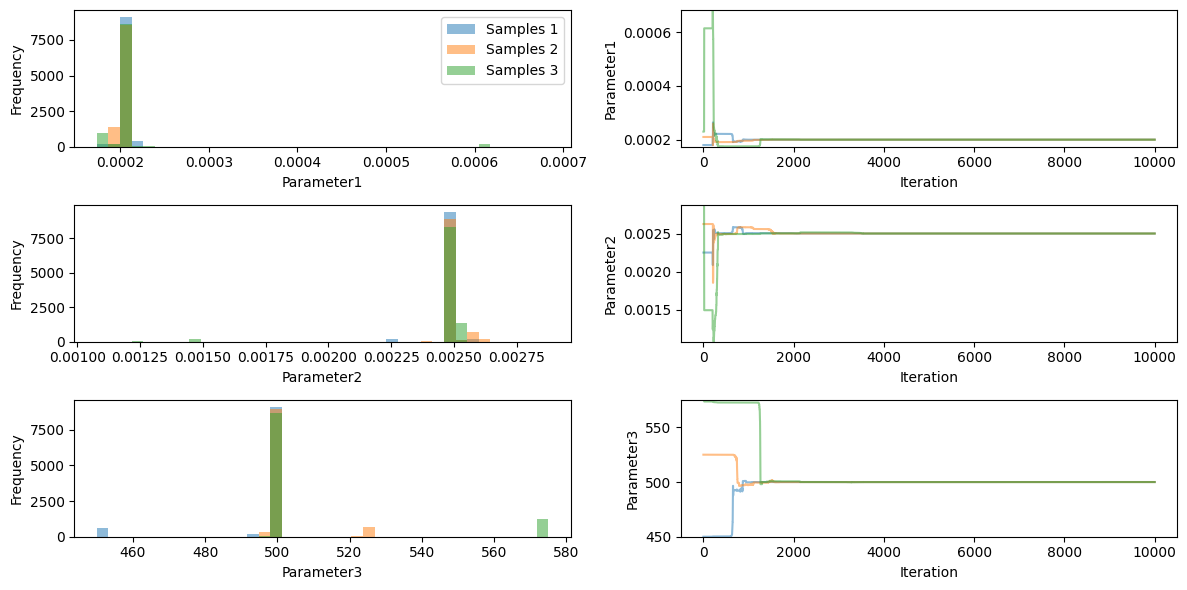

<class '__main__.MyMCMCSummary'>
param    mean    std.      2.5%    25%     50%     75%     97.5%    rhat    ess       ess per sec.
-------  ------  --------  ------  ------  ------  ------  -------  ------  --------  --------------
b        0.0002  2.16e-09  0.0002  0.0002  0.0002  0.0002  0.0002   1       1.24e+03  2.06
p        0.0025  7.21e-08  0.0025  0.0025  0.0025  0.0025  0.0025   1       1.13e+03  1.89
N        500     0.00225   500     500     500     500     500      1       1.32e+03  2.2


In [14]:
pints.plot.trace(chains_3)
plt.savefig("noisy_data_additive_moments_distribution.png")
plt.show()

parameter_names = ["b","p","N"]
results_3 = MyMCMCSummary(chains=chains_3[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results_3))
print(results_3)